<a href="https://colab.research.google.com/github/maazha55an/SharpDoc-TARA/blob/main/SharpDoc-TARA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:03<00:00, 145MB/s]


Epoch 1: train PSNR=9.70, val PSNR=10.21
Epoch 2: train PSNR=10.19, val PSNR=10.08


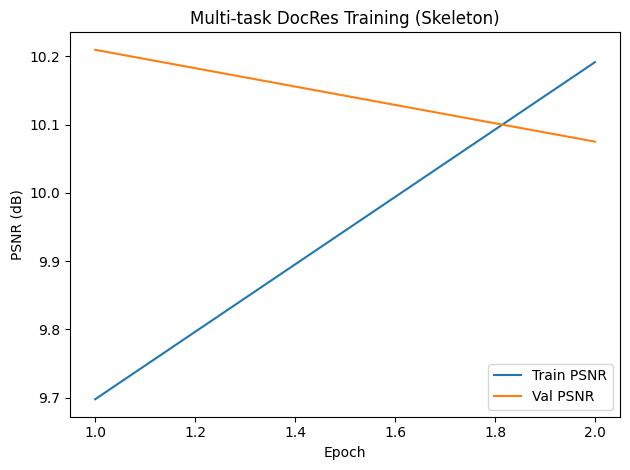

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------------
# 1. Dummy multi-task dataset
# ------------------------

TASKS = ["dewarp", "deshadow", "enhance", "deblur", "binarize"]
TASK_TO_IDX = {t: i for i, t in enumerate(TASKS)}

class DummyDocDataset(Dataset):
    def __init__(self, num_samples=200, image_size=128):
        self.num_samples = num_samples
        self.image_size = image_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # random source + "clean" target (replace with real doc pairs)
        Is = torch.rand(3, self.image_size, self.image_size)
        It = torch.rand(3, self.image_size, self.image_size)
        # random task
        task_idx = np.random.randint(0, len(TASKS))
        return Is, It, task_idx

train_ds = DummyDocDataset(num_samples=200)
val_ds   = DummyDocDataset(num_samples=50)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False)

# ------------------------
# 2. DTSPrompt stub (replace with real DTSPrompt logic)
# ------------------------

def build_dtsprompt(Is, task_idx_tensor):
    """
    Is: (B, 3, H, W)
    task_idx_tensor: (B,) integers
    Return: (B, 3, H, W) prompt
    Currently: simple per-task constant image, just to complete the pipeline.
    """
    B, C, H, W = Is.shape
    prompt = torch.zeros(B, 3, H, W, device=Is.device)
    for i in range(B):
        t = task_idx_tensor[i].item()
        val = (t + 1) / len(TASKS)  # encode task id
        prompt[i] = val
    return prompt

# ------------------------
# 3. DocRes-like generator with task adapters
#    (Improvement 2: task-adaptive modules)
# ------------------------

class TaskAdapter(nn.Module):
    def __init__(self, channels, num_tasks):
        super().__init__()
        self.adapters = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(channels, channels, 3, 1, 1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels, channels, 3, 1, 1)
            )
            for _ in range(num_tasks)
        ])

    def forward(self, x, task_idx):
        # task_idx is int (batch uses same task here for simplicity)
        return self.adapters[task_idx](x)

class SimpleBlockWithAdapter(nn.Module):
    def __init__(self, in_ch, num_tasks):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, in_ch, 3, 1, 1)
        self.relu = nn.ReLU(inplace=True)
        self.adapter = TaskAdapter(in_ch, num_tasks)

    def forward(self, x, task_idx):
        shared = self.relu(self.conv(x))
        adapted = self.adapter(shared, task_idx)
        return x + shared + adapted

class SimpleDocRes(nn.Module):
    def __init__(self, in_ch=6, base_ch=64, num_tasks=len(TASKS)):
        super().__init__()
        self.stem = nn.Conv2d(in_ch, base_ch, 3, 1, 1)
        self.block1 = SimpleBlockWithAdapter(base_ch, num_tasks)
        self.block2 = SimpleBlockWithAdapter(base_ch, num_tasks)
        self.head = nn.Conv2d(base_ch, 3, 3, 1, 1)

    def forward(self, Is, prompt, task_idx_tensor):
        # assume all samples in batch share the same task
        task_idx = int(task_idx_tensor[0].item())
        x = torch.cat([Is, prompt], dim=1)
        x = self.stem(x)
        x = self.block1(x, task_idx)
        x = self.block2(x, task_idx)
        out = self.head(x)
        return out

generator = SimpleDocRes().to(device)

# ------------------------
# 4. Perceptual loss (VGG) + PatchGAN discriminator
#    (Improvement 1: perceptual + adversarial losses)
# ------------------------

vgg = torchvision.models.vgg19(
    weights=torchvision.models.VGG19_Weights.DEFAULT
).features.to(device)
for p in vgg.parameters():
    p.requires_grad = False
vgg.eval()

def extract_features(x):
    feats = {}
    selected = [8, 17, 26]  # example VGG layers
    for i, layer in enumerate(vgg):
        x = layer(x)
        if i in selected:
            feats[i] = x
    return feats

class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_ch, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 1)  # patch-wise logits
        )

    def forward(self, x):
        return self.model(x)

disc = PatchDiscriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))

bce_loss = nn.BCEWithLogitsLoss()
l1_loss  = nn.L1Loss()

lambda_p   = 0.05  # perceptual weight
lambda_adv = 0.01  # GAN weight

# ------------------------
# 5. Metric helper (PSNR) + logging dict
# ------------------------

def compute_psnr(pred, target, eps=1e-8):
    mse = F.mse_loss(pred, target)
    psnr = -10.0 * torch.log10(mse + eps)
    return psnr.item()

history = {
    "epoch": [],
    "train_psnr": [],
    "val_psnr": []
}

# ------------------------
# 6. Training loop skeleton (tiny epochs, dummy data)
# ------------------------

num_epochs = 2  # increase once you hook up real data

for epoch in range(1, num_epochs + 1):
    generator.train()
    disc.train()

    train_psnr_accum = 0.0
    train_count = 0

    for Is, It, task_idx in train_loader:
        Is = Is.to(device)
        It = It.to(device)
        task_idx = task_idx.to(device)

        # build prompt (replace with real DTSPrompt)
        prompt = build_dtsprompt(Is, task_idx)

        # ---------------------------
        # 1) Train Discriminator
        # ---------------------------
        with torch.no_grad():
            fake = generator(Is, prompt, task_idx)

        pred_real = disc(It)
        label_real = torch.ones_like(pred_real)
        loss_D_real = bce_loss(pred_real, label_real)

        pred_fake = disc(fake.detach())
        label_fake = torch.zeros_like(pred_fake)
        loss_D_fake = bce_loss(pred_fake, label_fake)

        loss_D = 0.5 * (loss_D_real + loss_D_fake)

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # ---------------------------
        # 2) Train Generator
        # ---------------------------
        fake = generator(Is, prompt, task_idx)

        # here everything is treated as regression; for binarization
        # you would switch to BCE with logits on that task
        recon_loss = l1_loss(fake, It)

        # perceptual loss
        feats_fake = extract_features(fake)
        feats_real = extract_features(It)
        perc_loss = 0.0
        for k in feats_fake.keys():
            perc_loss = perc_loss + l1_loss(feats_fake[k], feats_real[k])
        perc_loss = perc_loss / max(len(feats_fake), 1)

        # GAN loss (generator wants discriminator to say "real")
        pred_fake_for_G = disc(fake)
        label_real_for_G = torch.ones_like(pred_fake_for_G)
        gan_loss = bce_loss(pred_fake_for_G, label_real_for_G)

        loss_G = recon_loss + lambda_p * perc_loss + lambda_adv * gan_loss

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        # accumulate train PSNR
        train_psnr_accum += compute_psnr(fake.detach(), It)
        train_count += 1

    # ---------------------------
    # Validation
    # ---------------------------
    generator.eval()
    val_psnr_accum = 0.0
    val_count = 0

    with torch.no_grad():
        for Is, It, task_idx in val_loader:
            Is = Is.to(device)
            It = It.to(device)
            task_idx = task_idx.to(device)
            prompt = build_dtsprompt(Is, task_idx)

            fake = generator(Is, prompt, task_idx)
            val_psnr_accum += compute_psnr(fake, It)
            val_count += 1

    train_psnr = train_psnr_accum / max(train_count, 1)
    val_psnr   = val_psnr_accum / max(val_count, 1)

    history["epoch"].append(epoch)
    history["train_psnr"].append(train_psnr)
    history["val_psnr"].append(val_psnr)

    print(f"Epoch {epoch}: train PSNR={train_psnr:.2f}, val PSNR={val_psnr:.2f}")

# ------------------------
# 7. Plotting training curves (auto from history)
# ------------------------

epochs = history["epoch"]
plt.plot(epochs, history["train_psnr"], label="Train PSNR")
plt.plot(epochs, history["val_psnr"], label="Val PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("Multi-task DocRes Training (Skeleton)")
plt.legend()
plt.tight_layout()
plt.show()


Using device: cpu


100%|██████████| 170M/170M [00:01<00:00, 102MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1: train PSNR=20.88, val PSNR=25.41, G loss=0.1022, D loss=0.4753
Epoch 2: train PSNR=26.55, val PSNR=28.44, G loss=0.0561, D loss=0.5528


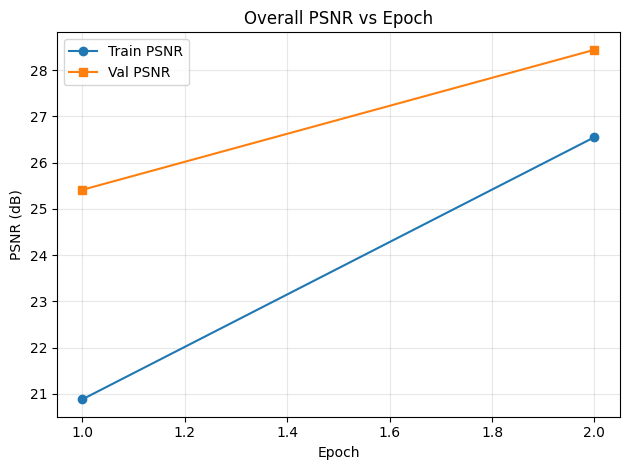

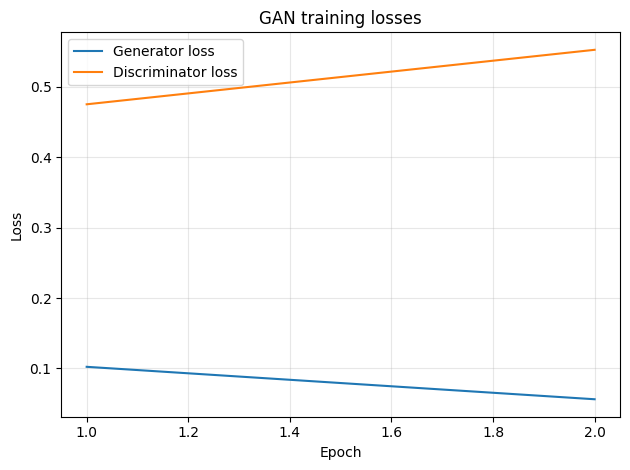

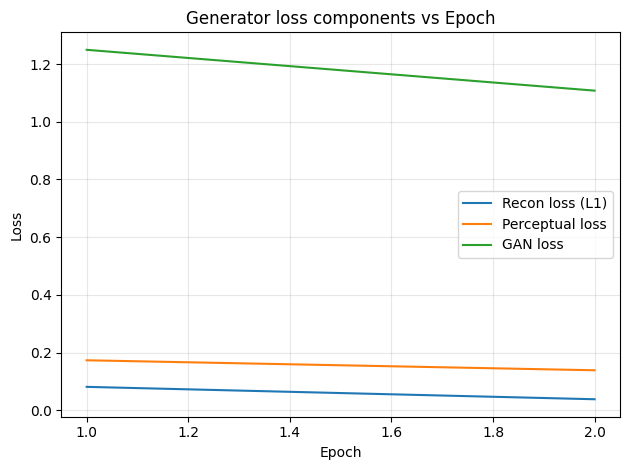

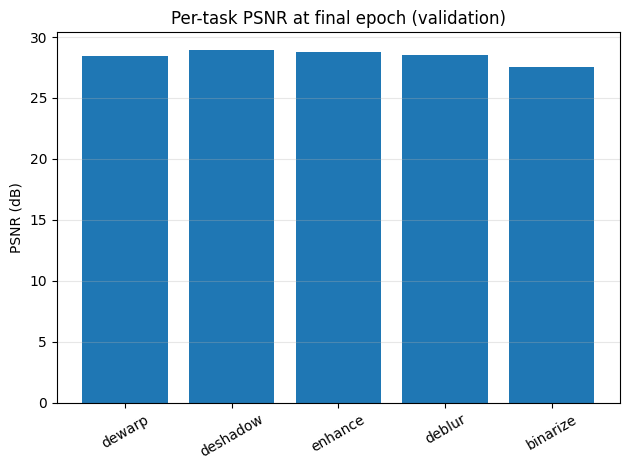

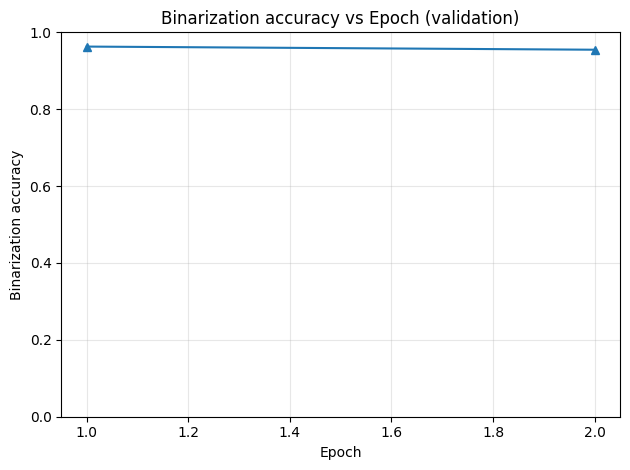

Training complete.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ------------------------
# 1. Multi-task setup
# ------------------------

TASKS = ["dewarp", "deshadow", "enhance", "deblur", "binarize"]
TASK_TO_IDX = {t: i for i, t in enumerate(TASKS)}

# ------------------------
# 2. Real dataset wrapper (CIFAR-10 as generic image source)
# ------------------------

class CIFARRestorationDataset(Dataset):
    """
    Uses CIFAR-10 images as 'documents'.
    Is = degraded version of image
    It = original image
    task_idx = random task id (for multi-task setting)
    """
    def __init__(self, train=True, image_size=128, max_samples=None):
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])
        self.base = datasets.CIFAR10(
            root="./data",
            train=train,
            download=True,
            transform=transform
        )
        self.image_size = image_size

        self.indices = list(range(len(self.base)))
        if max_samples is not None:
            self.indices = self.indices[:max_samples]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, _ = self.base[self.indices[idx]]  # img in [0,1], shape (3,H,W)
        It = img.clone()

        # Simple degradation: add Gaussian noise
        noise = 0.05 * torch.randn_like(It)
        Is = torch.clamp(It + noise, 0.0, 1.0)

        task_idx = np.random.randint(0, len(TASKS))
        return Is, It, task_idx

# Create train/val loaders
train_ds = CIFARRestorationDataset(train=True,  image_size=128, max_samples=2000)
val_ds   = CIFARRestorationDataset(train=False, image_size=128, max_samples=500)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# ------------------------
# 3. DTSPrompt stub
# ------------------------

def build_dtsprompt(Is, task_idx_tensor):
    """
    Is: (B, 3, H, W)
    task_idx_tensor: (B,) integers
    Return: (B, 3, H, W) prompt
    Here: simple per-task constant plane to encode task id.
    """
    B, C, H, W = Is.shape
    prompt = torch.zeros(B, 3, H, W, device=Is.device)
    for i in range(B):
        t = int(task_idx_tensor[i].item())
        val = (t + 1) / len(TASKS)  # encode task id
        prompt[i] = val
    return prompt

# ------------------------
# 4. DocRes-like generator with task adapters
# ------------------------

class TaskAdapter(nn.Module):
    def __init__(self, channels, num_tasks):
        super().__init__()
        self.adapters = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(channels, channels, 3, 1, 1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels, channels, 3, 1, 1)
            )
            for _ in range(num_tasks)
        ])

    def forward(self, x, task_idx):
        # task_idx is an int (we use the first sample's task for the whole batch)
        return self.adapters[task_idx](x)

class SimpleBlockWithAdapter(nn.Module):
    def __init__(self, in_ch, num_tasks):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, in_ch, 3, 1, 1)
        self.relu = nn.ReLU(inplace=True)
        self.adapter = TaskAdapter(in_ch, num_tasks)

    def forward(self, x, task_idx):
        shared = self.relu(self.conv(x))
        adapted = self.adapter(shared, task_idx)
        return x + shared + adapted

class SimpleDocRes(nn.Module):
    def __init__(self, in_ch=6, base_ch=64, num_tasks=len(TASKS)):
        super().__init__()
        self.stem = nn.Conv2d(in_ch, base_ch, 3, 1, 1)
        self.block1 = SimpleBlockWithAdapter(base_ch, num_tasks)
        self.block2 = SimpleBlockWithAdapter(base_ch, num_tasks)
        self.head = nn.Conv2d(base_ch, 3, 3, 1, 1)
        self.num_tasks = num_tasks

    def forward(self, Is, prompt, task_idx_tensor):
        # assume all samples in batch share the same task id
        task_idx = int(task_idx_tensor[0].item())
        x = torch.cat([Is, prompt], dim=1)
        x = self.stem(x)
        x = self.block1(x, task_idx)
        x = self.block2(x, task_idx)
        out = self.head(x)
        out = torch.sigmoid(out)  # keep output in [0,1]
        return out

generator = SimpleDocRes().to(device)

# ------------------------
# 5. Perceptual loss (VGG) + PatchGAN discriminator
# ------------------------

# Handle both old and new torchvision APIs for vgg19
try:
    vgg = torchvision.models.vgg19(
        weights=torchvision.models.VGG19_Weights.DEFAULT
    ).features.to(device)
except Exception:
    vgg = torchvision.models.vgg19(pretrained=True).features.to(device)

for p in vgg.parameters():
    p.requires_grad = False
vgg.eval()

def extract_features(x):
    feats = {}
    selected = [8, 17, 26]  # example VGG layers
    for i, layer in enumerate(vgg):
        x = layer(x)
        if i in selected:
            feats[i] = x
    return feats

class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_ch, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 1)  # patch-wise logits
        )

    def forward(self, x):
        return self.model(x)

disc = PatchDiscriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(disc.parameters(),      lr=2e-4, betas=(0.5, 0.999))

bce_loss = nn.BCEWithLogitsLoss()
l1_loss  = nn.L1Loss()

lambda_p   = 0.05  # perceptual weight
lambda_adv = 0.01  # GAN weight

# ------------------------
# 6. Metric helpers + history
# ------------------------

def compute_psnr(pred, target, eps=1e-8):
    mse = F.mse_loss(pred, target)
    psnr = -10.0 * torch.log10(mse + eps)
    return psnr.item()

def compute_binar_accuracy(pred, target, thresh=0.5):
    """
    pred, target: (B,1,H,W) or (B,3,H,W) in [0,1]
    Returns scalar accuracy.
    """
    if pred.ndim == 4:
        pred_gray = pred.mean(dim=1)  # simple grayscale
    else:
        pred_gray = pred
    if target.ndim == 4:
        target_gray = target.mean(dim=1)
    else:
        target_gray = target

    pred_bin   = (pred_gray > thresh).float()
    target_bin = (target_gray > thresh).float()
    correct = (pred_bin == target_bin).float().mean()
    return correct.item()

history = {
    "epoch": [],
    "train_psnr": [],
    "val_psnr": [],
    "train_G_loss": [],
    "train_D_loss": [],
    "train_recon_loss": [],
    "train_perc_loss": [],
    "train_gan_loss": [],
    "val_psnr_task": {t: [] for t in TASKS},
    "val_binar_acc": []
}

# ------------------------
# 7. Training loop
# ------------------------

num_epochs = 2  # increase for more serious training

for epoch in range(1, num_epochs + 1):
    generator.train()
    disc.train()

    train_psnr_accum = 0.0
    train_count = 0

    G_loss_accum = 0.0
    D_loss_accum = 0.0
    recon_loss_accum = 0.0
    perc_loss_accum = 0.0
    gan_loss_accum = 0.0

    # --------- Training ---------
    for Is, It, task_idx in train_loader:
        Is = Is.to(device)
        It = It.to(device)
        task_idx = task_idx.to(device)

        # build prompt
        prompt = build_dtsprompt(Is, task_idx)

        # --- Train Discriminator ---
        with torch.no_grad():
            fake = generator(Is, prompt, task_idx)

        pred_real = disc(It)
        label_real = torch.ones_like(pred_real)
        loss_D_real = bce_loss(pred_real, label_real)

        pred_fake = disc(fake.detach())
        label_fake = torch.zeros_like(pred_fake)
        loss_D_fake = bce_loss(pred_fake, label_fake)

        loss_D = 0.5 * (loss_D_real + loss_D_fake)
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # --- Train Generator ---
        fake = generator(Is, prompt, task_idx)
        recon_loss = l1_loss(fake, It)

        feats_fake = extract_features(fake)
        feats_real = extract_features(It)
        perc_loss = 0.0
        for k in feats_fake.keys():
            perc_loss = perc_loss + l1_loss(feats_fake[k], feats_real[k])
        if len(feats_fake) > 0:
            perc_loss = perc_loss / len(feats_fake)

        pred_fake_for_G = disc(fake)
        label_real_for_G = torch.ones_like(pred_fake_for_G)
        gan_loss = bce_loss(pred_fake_for_G, label_real_for_G)

        loss_G = recon_loss + lambda_p * perc_loss + lambda_adv * gan_loss

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        # metrics
        batch_psnr = compute_psnr(fake.detach(), It)
        train_psnr_accum += batch_psnr
        train_count += 1

        G_loss_accum     += loss_G.item()
        D_loss_accum     += loss_D.item()
        recon_loss_accum += recon_loss.item()
        perc_loss_accum  += perc_loss.item()
        gan_loss_accum   += gan_loss.item()

    # --------- Validation ---------
    generator.eval()
    disc.eval()
    val_psnr_accum = 0.0
    val_count = 0

    val_psnr_task_accum = {t: 0.0 for t in TASKS}
    val_psnr_task_count = {t: 0 for t in TASKS}
    binar_acc_accum = 0.0
    binar_acc_count = 0

    with torch.no_grad():
        for Is, It, task_idx in val_loader:
            Is = Is.to(device)
            It = It.to(device)
            task_idx = task_idx.to(device)
            prompt = build_dtsprompt(Is, task_idx)

            fake = generator(Is, prompt, task_idx)

            # PSNR per sample
            B = Is.size(0)
            for i in range(B):
                psnr_i = compute_psnr(fake[i:i+1], It[i:i+1])
                val_psnr_accum += psnr_i
                val_count += 1

                t_idx = int(task_idx[i].item())
                t_name = TASKS[t_idx]
                val_psnr_task_accum[t_name] += psnr_i
                val_psnr_task_count[t_name] += 1

                # Example binarization accuracy (dummy, uses grayscale)
                if t_name == "binarize":
                    acc_i = compute_binar_accuracy(
                        fake[i:i+1], It[i:i+1], thresh=0.5
                    )
                    binar_acc_accum += acc_i
                    binar_acc_count += 1

    train_psnr = train_psnr_accum / max(train_count, 1)
    val_psnr   = val_psnr_accum / max(val_count, 1)
    num_batches = max(train_count, 1)

    history["epoch"].append(epoch)
    history["train_psnr"].append(train_psnr)
    history["val_psnr"].append(val_psnr)
    history["train_G_loss"].append(G_loss_accum / num_batches)
    history["train_D_loss"].append(D_loss_accum / num_batches)
    history["train_recon_loss"].append(recon_loss_accum / num_batches)
    history["train_perc_loss"].append(perc_loss_accum / num_batches)
    history["train_gan_loss"].append(gan_loss_accum / num_batches)

    for t in TASKS:
        if val_psnr_task_count[t] > 0:
            history["val_psnr_task"][t].append(
                val_psnr_task_accum[t] / val_psnr_task_count[t]
            )
        else:
            history["val_psnr_task"][t].append(0.0)

    if binar_acc_count > 0:
        history["val_binar_acc"].append(binar_acc_accum / binar_acc_count)
    else:
        history["val_binar_acc"].append(0.0)

    print(f"Epoch {epoch}: "
          f"train PSNR={train_psnr:.2f}, val PSNR={val_psnr:.2f}, "
          f"G loss={history['train_G_loss'][-1]:.4f}, "
          f"D loss={history['train_D_loss'][-1]:.4f}")

# ------------------------
# 8. Plotting graphs
# ------------------------

epochs = history["epoch"]

# 8.1 PSNR vs epoch
plt.figure()
plt.plot(epochs, history["train_psnr"], marker="o", label="Train PSNR")
plt.plot(epochs, history["val_psnr"], marker="s", label="Val PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("Overall PSNR vs Epoch")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8.2 Generator & Discriminator loss curves
plt.figure()
plt.plot(epochs, history["train_G_loss"], label="Generator loss")
plt.plot(epochs, history["train_D_loss"], label="Discriminator loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN training losses")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8.3 Loss breakdown
plt.figure()
plt.plot(epochs, history["train_recon_loss"], label="Recon loss (L1)")
plt.plot(epochs, history["train_perc_loss"],  label="Perceptual loss")
plt.plot(epochs, history["train_gan_loss"],   label="GAN loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator loss components vs Epoch")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8.4 Per-task PSNR bar chart (validation, last epoch)
final_psnr_per_task = [history["val_psnr_task"][t][-1] for t in TASKS]
x = np.arange(len(TASKS))
plt.figure()
plt.bar(x, final_psnr_per_task)
plt.xticks(x, TASKS, rotation=30)
plt.ylabel("PSNR (dB)")
plt.title("Per-task PSNR at final epoch (validation)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 8.5 Binarization accuracy vs epoch (dummy, but structure is ready)
plt.figure()
plt.plot(epochs, history["val_binar_acc"], marker="^")
plt.xlabel("Epoch")
plt.ylabel("Binarization accuracy")
plt.ylim(0, 1)
plt.title("Binarization accuracy vs Epoch (validation)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Training complete.")


Using device: cpu


100%|██████████| 170M/170M [00:02<00:00, 71.8MB/s]


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 78.9MB/s]



=== Running experiment: DocRes_baseline ===


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1: train PSNR=13.39, val PSNR=17.05, G loss=0.1569, D loss=0.0000

=== Running experiment: DocRes_TARA ===
Epoch 1: train PSNR=12.89, val PSNR=16.92, G loss=0.1705, D loss=0.0000

=== Running experiment: DocRes_PercGAN ===
Epoch 1: train PSNR=13.17, val PSNR=16.71, G loss=0.1927, D loss=0.3915

=== Running experiment: DocTARA_full ===
Epoch 1: train PSNR=13.16, val PSNR=16.72, G loss=0.1883, D loss=0.4281

All experiments finished.


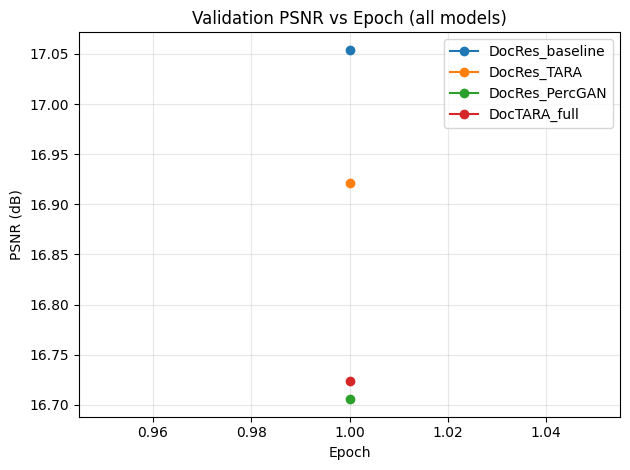

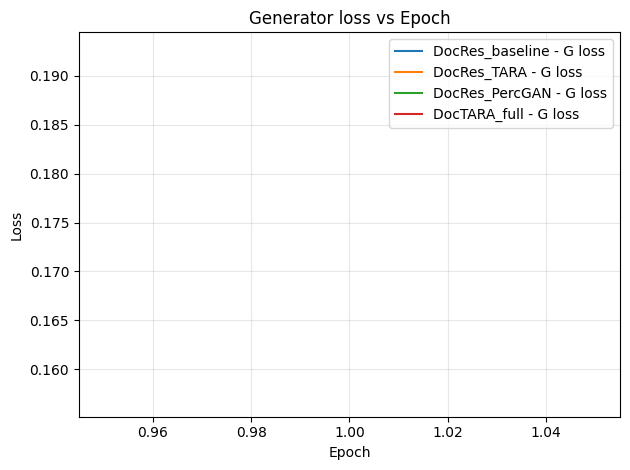

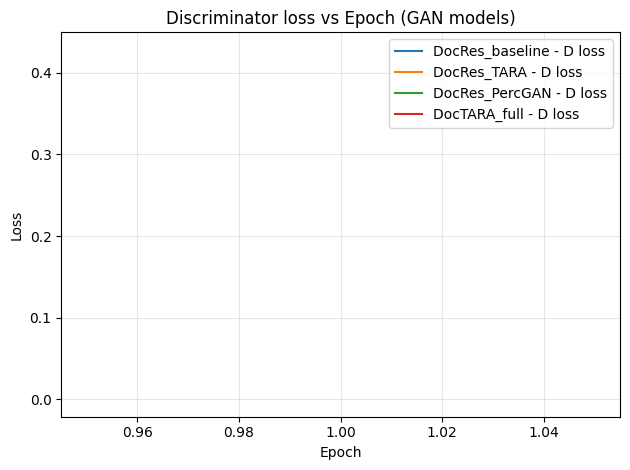

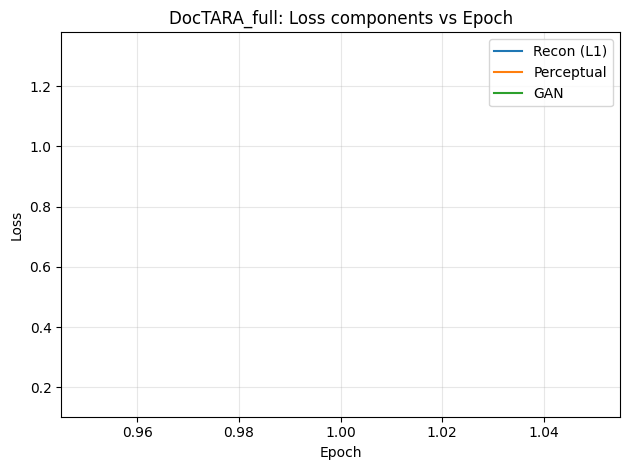

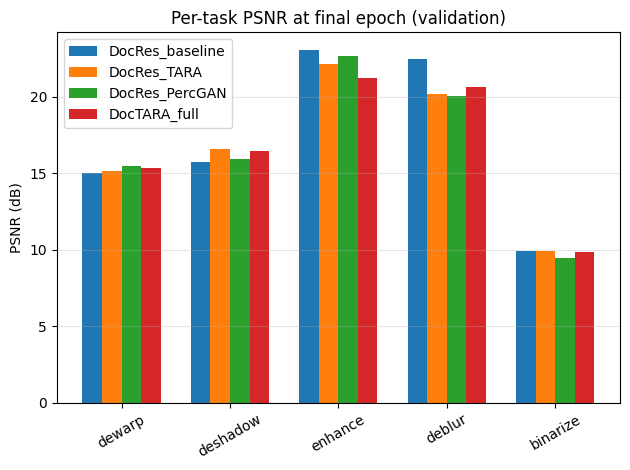


=== Summary table (overall + per-task PSNR, final epoch) ===
Model               Overall dewarp_PSNR deshadow_PSNR enhance_PSNR deblur_PSNR binarize_PSNR
DocRes_baseline       17.05      15.04      15.76      23.07      22.49       9.90
DocRes_TARA           16.92      15.17      16.59      22.12      20.21       9.96
DocRes_PercGAN        16.71      15.49      15.94      22.67      20.06       9.44
DocTARA_full          16.72      15.38      16.44      21.23      20.62       9.84

LaTeX-style table (copy into paper and tweak caption):
\begin{tabular}{lcccccc}
\toprule
Model & Overall & dewarp & deshadow & enhance & deblur & binarize \\
\midrule
DocRes_baseline & 17.05 & 15.04 & 15.76 & 23.07 & 22.49 & 9.90 \\
DocRes_TARA & 16.92 & 15.17 & 16.59 & 22.12 & 20.21 & 9.96 \\
DocRes_PercGAN & 16.71 & 15.49 & 15.94 & 22.67 & 20.06 & 9.44 \\
DocTARA_full & 16.72 & 15.38 & 16.44 & 21.23 & 20.62 & 9.84 \\
\bottomrule
\end{tabular}
Demo sample idx=297, task=deshadow


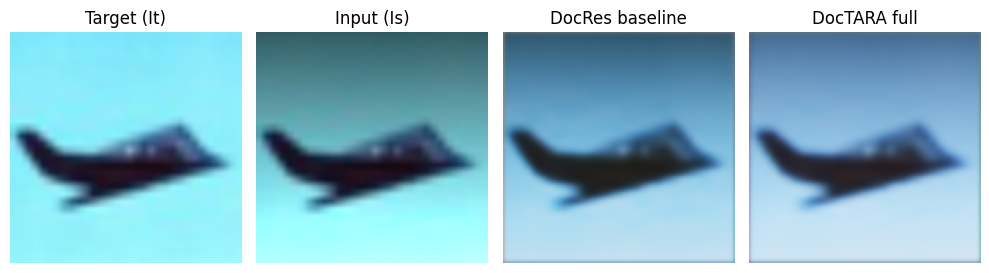

Done.


In [ ]:
# ================================
# DocTARA vs DocRes – Colab script
# ================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import functional as TF
import matplotlib.pyplot as plt
import numpy as np
import random

# ------------------------
# 0. Device & config
# ------------------------

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

TASKS = ["dewarp", "deshadow", "enhance", "deblur", "binarize"]
TASK_TO_IDX = {t: i for i, t in enumerate(TASKS)}

# For quick Colab runs. Increase later (e.g. 5–20) for real experiments.
NUM_EPOCHS_BASELINE = 1
NUM_EPOCHS_TARA     = 1

MAX_TRAIN_SAMPLES = 2000  # subset for speed
MAX_VAL_SAMPLES   = 500

BATCH_SIZE = 16
IMAGE_SIZE = 128

lambda_p   = 0.05  # perceptual loss weight
lambda_adv = 0.01  # GAN loss weight

# ------------------------
# 1. Dataset: CIFAR10 -> synthetic "doc" tasks
# ------------------------

class DocCIFARDataset(Dataset):
    """
    Uses CIFAR-10 images as a proxy for document images.
    For each sample, we:
      - pick a random task
      - generate a degraded input Is based on that task
      - set the target It according to the task
    """
    def __init__(self, train=True, image_size=128, max_samples=None):
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])
        self.base = datasets.CIFAR10(
            root="./data",
            train=train,
            download=True,
            transform=transform
        )
        self.indices = list(range(len(self.base)))
        if max_samples is not None:
            self.indices = self.indices[:max_samples]
        self.image_size = image_size

    def __len__(self):
        return len(self.indices)

    def apply_degradation(self, img, task_name):
        """
        img: Tensor (3,H,W) in [0,1]
        Returns:
          Is: degraded input
          It: target "clean" image for that task
        """
        if task_name == "dewarp":
            # Simple random affine / perspective-like distortion
            angle = 0.0
            translate = (np.random.randint(-10, 10),
                         np.random.randint(-10, 10))
            scale = np.random.uniform(0.9, 1.1)
            shear = (np.random.uniform(-10, 10),
                     np.random.uniform(-10, 10))
            Is = TF.affine(img, angle=angle,
                           translate=translate,
                           scale=scale,
                           shear=shear)
            It = img  # target is original
        elif task_name == "deshadow":
            C, H, W = img.shape
            grad = torch.linspace(0.4, 1.2, steps=H).view(1, H, 1)
            grad = grad.to(img.device)
            Is = torch.clamp(img * grad, 0.0, 1.0)
            It = img
        elif task_name == "enhance":
            # Darker, low-contrast input as degraded
            factor = np.random.uniform(0.5, 0.8)
            Is = torch.clamp(img * factor + (1 - factor) * 0.5, 0.0, 1.0)
            It = img
        elif task_name == "deblur":
            # Gaussian blur as degradation
            kernel_size = 7
            sigma = np.random.uniform(1.0, 2.5)
            blur = transforms.GaussianBlur(kernel_size=kernel_size,
                                           sigma=sigma)
            Is = blur(img)
            It = img
        elif task_name == "binarize":
            # Input: grayscale-ish, noisy
            # Target: "binarized" map repeated in 3 channels
            gray = img.mean(dim=0, keepdim=True)
            noise = 0.1 * torch.randn_like(gray)
            Is_gray = torch.clamp(gray + noise, 0.0, 1.0)

            thresh = gray.mean()
            bin_map = (gray > thresh).float()
            It = bin_map.repeat(3, 1, 1)   # 3-channel binary target
            Is = Is_gray.repeat(3, 1, 1)   # 3-channel noisy grayscale
        else:
            Is = img
            It = img
        return Is, It

    def __getitem__(self, idx):
        img, _ = self.base[self.indices[idx]]
        task_idx = np.random.randint(0, len(TASKS))
        task_name = TASKS[task_idx]
        Is, It = self.apply_degradation(img, task_name)
        return Is, It, task_idx

# Train/val loaders
train_ds = DocCIFARDataset(train=True,  image_size=IMAGE_SIZE,
                           max_samples=MAX_TRAIN_SAMPLES)
val_ds   = DocCIFARDataset(train=False, image_size=IMAGE_SIZE,
                           max_samples=MAX_VAL_SAMPLES)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2, pin_memory=True)

# ------------------------
# 2. DTSPrompt stub (DocRes-style)
# ------------------------

def build_dtsprompt(Is, task_idx_tensor):
    """
    Very simple DTSPrompt:
    Each task gets a constant 3-channel plane with a distinct value.
    Shape: (B,3,H,W)
    """
    B, C, H, W = Is.shape
    prompt = torch.zeros(B, 3, H, W, device=Is.device)
    for i in range(B):
        t = int(task_idx_tensor[i].item())
        val = (t + 1) / len(TASKS)
        prompt[i] = val
    return prompt

# ------------------------
# 3. DocRes-style generator with optional TARA adapters
# ------------------------

class TaskAdapter(nn.Module):
    def __init__(self, channels, num_tasks):
        super().__init__()
        self.adapters = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(channels, channels, 3, 1, 1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channels, channels, 3, 1, 1)
            )
            for _ in range(num_tasks)
        ])

    def forward(self, x, task_idx):
        return self.adapters[task_idx](x)

class SimpleSharedBlock(nn.Module):
    """No adapters, used for baseline."""
    def __init__(self, in_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, in_ch, 3, 1, 1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, task_idx=None):
        shared = self.relu(self.conv(x))
        return x + shared

class SimpleBlockWithAdapter(nn.Module):
    """Shared conv + task-specific adapter residual."""
    def __init__(self, in_ch, num_tasks):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, in_ch, 3, 1, 1)
        self.relu = nn.ReLU(inplace=True)
        self.adapter = TaskAdapter(in_ch, num_tasks)

    def forward(self, x, task_idx):
        shared = self.relu(self.conv(x))
        adapted = self.adapter(shared, task_idx)
        return x + shared + adapted

class SimpleDocRes(nn.Module):
    """
    Lightweight DocRes-style generator.

    - in_ch=6: input image (3) + DTSPrompt (3)
    - use_adapters=False -> shared blocks only (DocRes baseline)
    - use_adapters=True  -> TARA (DocTARA)
    """
    def __init__(self, in_ch=6, base_ch=64, num_tasks=len(TASKS),
                 use_adapters=False):
        super().__init__()
        self.use_adapters = use_adapters
        self.stem = nn.Conv2d(in_ch, base_ch, 3, 1, 1)
        if use_adapters:
            self.block1 = SimpleBlockWithAdapter(base_ch, num_tasks)
            self.block2 = SimpleBlockWithAdapter(base_ch, num_tasks)
        else:
            self.block1 = SimpleSharedBlock(base_ch)
            self.block2 = SimpleSharedBlock(base_ch)
        self.head = nn.Conv2d(base_ch, 3, 3, 1, 1)

    def forward(self, Is, prompt, task_idx_tensor):
        # assume batch is mostly one task; use first sample's task ID
        task_idx = int(task_idx_tensor[0].item())
        x = torch.cat([Is, prompt], dim=1)
        x = self.stem(x)
        x = self.block1(x, task_idx)
        x = self.block2(x, task_idx)
        out = self.head(x)
        out = torch.sigmoid(out)  # outputs in [0,1]
        return out

# ------------------------
# 4. Perceptual loss (VGG19) + PatchGAN discriminator
# ------------------------

# Handle both older & newer torchvision APIs for vgg19
try:
    vgg = torchvision.models.vgg19(
        weights=torchvision.models.VGG19_Weights.DEFAULT
    ).features.to(device)
except Exception:
    vgg = torchvision.models.vgg19(pretrained=True).features.to(device)

for p in vgg.parameters():
    p.requires_grad = False
vgg.eval()

def extract_features(x):
    feats = {}
    selected = [8, 17, 26]  # example layers
    for i, layer in enumerate(vgg):
        x = layer(x)
        if i in selected:
            feats[i] = x
    return feats

class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_ch, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 1)  # patch-wise logits
        )

    def forward(self, x):
        return self.model(x)

bce_loss = nn.BCEWithLogitsLoss()
l1_loss  = nn.L1Loss()

# ------------------------
# 5. Metrics & history helpers
# ------------------------

def compute_psnr(pred, target, eps=1e-8):
    mse = F.mse_loss(pred, target)
    psnr = -10.0 * torch.log10(mse + eps)
    return psnr.item()

def init_history():
    return {
        "epoch": [],
        "train_psnr": [],
        "val_psnr": [],
        "train_G_loss": [],
        "train_D_loss": [],
        "train_recon_loss": [],
        "train_perc_loss": [],
        "train_gan_loss": [],
        "val_psnr_task": {t: [] for t in TASKS},
    }

# ------------------------
# 6. Experiment runner
# ------------------------

def run_experiment(
    name,
    use_adapters=False,
    use_gan=False,
    use_perc=False,
    num_epochs=1
):
    print(f"\n=== Running experiment: {name} ===")
    history = init_history()

    generator = SimpleDocRes(use_adapters=use_adapters).to(device)
    disc = PatchDiscriminator().to(device) if use_gan else None

    optimizer_G = torch.optim.Adam(
        generator.parameters(), lr=2e-4, betas=(0.5, 0.999)
    )
    if use_gan:
        optimizer_D = torch.optim.Adam(
            disc.parameters(), lr=2e-4, betas=(0.5, 0.999)
        )
    else:
        optimizer_D = None

    for epoch in range(1, num_epochs + 1):
        generator.train()
        if use_gan:
            disc.train()

        train_psnr_accum = 0.0
        train_count = 0

        G_loss_accum = 0.0
        D_loss_accum = 0.0
        recon_loss_accum = 0.0
        perc_loss_accum = 0.0
        gan_loss_accum = 0.0

        # ---- Training loop ----
        for Is, It, task_idx in train_loader:
            Is = Is.to(device)
            It = It.to(device)
            task_idx = task_idx.to(device)

            prompt = build_dtsprompt(Is, task_idx)

            # 1) Train Discriminator (if using GAN)
            if use_gan:
                with torch.no_grad():
                    fake = generator(Is, prompt, task_idx)

                pred_real = disc(It)
                label_real = torch.ones_like(pred_real)
                loss_D_real = bce_loss(pred_real, label_real)

                pred_fake = disc(fake.detach())
                label_fake = torch.zeros_like(pred_fake)
                loss_D_fake = bce_loss(pred_fake, label_fake)

                loss_D = 0.5 * (loss_D_real + loss_D_fake)

                optimizer_D.zero_grad()
                loss_D.backward()
                optimizer_D.step()

                D_loss_accum += loss_D.item()
            else:
                loss_D = torch.tensor(0.0)

            # 2) Train Generator
            fake = generator(Is, prompt, task_idx)
            recon_loss = l1_loss(fake, It)

            if use_perc:
                feats_fake = extract_features(fake)
                feats_real = extract_features(It)
                perc_loss = 0.0
                for k in feats_fake.keys():
                    perc_loss = perc_loss + l1_loss(feats_fake[k], feats_real[k])
                if len(feats_fake) > 0:
                    perc_loss = perc_loss / len(feats_fake)
            else:
                perc_loss = torch.tensor(0.0, device=device)

            if use_gan:
                pred_fake_for_G = disc(fake)
                label_real_for_G = torch.ones_like(pred_fake_for_G)
                gan_loss = bce_loss(pred_fake_for_G, label_real_for_G)
            else:
                gan_loss = torch.tensor(0.0, device=device)

            loss_G = recon_loss + lambda_p * perc_loss + lambda_adv * gan_loss

            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()

            # metrics
            batch_psnr = compute_psnr(fake.detach(), It)
            train_psnr_accum += batch_psnr
            train_count += 1

            G_loss_accum     += loss_G.item()
            recon_loss_accum += recon_loss.item()
            perc_loss_accum  += perc_loss.item() if use_perc else 0.0
            gan_loss_accum   += gan_loss.item() if use_gan else 0.0

        # ---- Validation loop ----
        generator.eval()
        if use_gan:
            disc.eval()

        val_psnr_accum = 0.0
        val_count = 0
        val_psnr_task_accum = {t: 0.0 for t in TASKS}
        val_psnr_task_count = {t: 0 for t in TASKS}

        with torch.no_grad():
            for Is, It, task_idx in val_loader:
                Is = Is.to(device)
                It = It.to(device)
                task_idx = task_idx.to(device)
                prompt = build_dtsprompt(Is, task_idx)

                fake = generator(Is, prompt, task_idx)
                B = Is.size(0)

                for i in range(B):
                    psnr_i = compute_psnr(fake[i:i+1], It[i:i+1])
                    val_psnr_accum += psnr_i
                    val_count += 1

                    t_idx = int(task_idx[i].item())
                    t_name = TASKS[t_idx]
                    val_psnr_task_accum[t_name] += psnr_i
                    val_psnr_task_count[t_name] += 1

        train_psnr = train_psnr_accum / max(train_count, 1)
        val_psnr   = val_psnr_accum   / max(val_count,   1)
        num_batches = max(train_count, 1)

        history["epoch"].append(epoch)
        history["train_psnr"].append(train_psnr)
        history["val_psnr"].append(val_psnr)
        history["train_G_loss"].append(G_loss_accum / num_batches)
        history["train_D_loss"].append(D_loss_accum / num_batches if use_gan else 0.0)
        history["train_recon_loss"].append(recon_loss_accum / num_batches)
        history["train_perc_loss"].append(perc_loss_accum / num_batches if use_perc else 0.0)
        history["train_gan_loss"].append(gan_loss_accum / num_batches if use_gan else 0.0)

        for t in TASKS:
            if val_psnr_task_count[t] > 0:
                history["val_psnr_task"][t].append(
                    val_psnr_task_accum[t] / val_psnr_task_count[t]
                )
            else:
                history["val_psnr_task"][t].append(0.0)

        print(
            f"Epoch {epoch}: "
            f"train PSNR={train_psnr:.2f}, val PSNR={val_psnr:.2f}, "
            f"G loss={history['train_G_loss'][-1]:.4f}, "
            f"D loss={history['train_D_loss'][-1]:.4f}"
        )

    return history, generator

# ------------------------
# 7. Run all variants
# ------------------------

experiments = {
    "DocRes_baseline": dict(
        use_adapters=False,
        use_gan=False,
        use_perc=False,
        num_epochs=NUM_EPOCHS_BASELINE
    ),
    "DocRes_TARA": dict(
        use_adapters=True,
        use_gan=False,
        use_perc=False,
        num_epochs=NUM_EPOCHS_TARA
    ),
    "DocRes_PercGAN": dict(
        use_adapters=False,
        use_gan=True,
        use_perc=True,
        num_epochs=NUM_EPOCHS_TARA
    ),
    "DocTARA_full": dict(
        use_adapters=True,
        use_gan=True,
        use_perc=True,
        num_epochs=NUM_EPOCHS_TARA
    ),
}

histories = {}
generators = {}

for name, cfg in experiments.items():
    hist, gen = run_experiment(name, **cfg)
    histories[name] = hist
    generators[name] = gen

print("\nAll experiments finished.")

# ------------------------
# 8. Plots: PSNR & losses
# ------------------------

# 8.1 PSNR vs epoch (val)
plt.figure()
for name, hist in histories.items():
    plt.plot(hist["epoch"], hist["val_psnr"], marker="o", label=name)
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("Validation PSNR vs Epoch (all models)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8.2 Generator & Discriminator loss curves
plt.figure()
for name, hist in histories.items():
    plt.plot(hist["epoch"], hist["train_G_loss"], label=f"{name} - G loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator loss vs Epoch")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure()
for name, hist in histories.items():
    plt.plot(hist["epoch"], hist["train_D_loss"], label=f"{name} - D loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator loss vs Epoch (GAN models)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8.3 Generator loss components (for one model, e.g. DocTARA_full)
if "DocTARA_full" in histories:
    hist = histories["DocTARA_full"]
    epochs = hist["epoch"]
    plt.figure()
    plt.plot(epochs, hist["train_recon_loss"], label="Recon (L1)")
    plt.plot(epochs, hist["train_perc_loss"],  label="Perceptual")
    plt.plot(epochs, hist["train_gan_loss"],   label="GAN")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("DocTARA_full: Loss components vs Epoch")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 8.4 Per-task PSNR bar chart (final epoch)
tasks = TASKS
x = np.arange(len(tasks))
width = 0.18

plt.figure()
for i, (name, hist) in enumerate(histories.items()):
    vals = [hist["val_psnr_task"][t][-1] for t in tasks]
    plt.bar(x + i * width, vals, width=width, label=name)

plt.xticks(x + width * (len(histories) - 1) / 2, tasks, rotation=30)
plt.ylabel("PSNR (dB)")
plt.title("Per-task PSNR at final epoch (validation)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------
# 9. Comparative table (DocRes vs DocTARA variants)
# ------------------------

print("\n=== Summary table (overall + per-task PSNR, final epoch) ===")
header = ["Model", "Overall"] + [f"{t}_PSNR" for t in TASKS]
print("{:<18} {:>8} ".format(header[0], header[1]) +
      " ".join([f"{h:>10}" for h in header[2:]]))

for name, hist in histories.items():
    overall = hist["val_psnr"][-1]
    per_task = [hist["val_psnr_task"][t][-1] for t in TASKS]
    row = f"{name:<18} {overall:8.2f} " + " ".join([f"{v:10.2f}" for v in per_task])
    print(row)

print("\nLaTeX-style table (copy into paper and tweak caption):")
col_spec = "l" + "c" * (1 + len(TASKS))
print("\\begin{tabular}{" + col_spec + "}")
print("\\toprule")
print("Model & Overall & " + " & ".join(TASKS) + " \\\\")
print("\\midrule")
for name, hist in histories.items():
    overall = hist["val_psnr"][-1]
    per_task = [hist["val_psnr_task"][t][-1] for t in TASKS]
    vals_str = " & ".join([f"{v:.2f}" for v in per_task])
    print(f"{name} & {overall:.2f} & {vals_str} \\\\")
print("\\bottomrule")
print("\\end{tabular}")

# ------------------------
# 10. Single-image demo: input vs DocRes vs DocTARA
# ------------------------

def show_demo_sample(idx=None):
    """Pick a sample from val_ds and show original / degraded / outputs."""
    if idx is None:
        idx = random.randint(0, len(val_ds) - 1)
    Is, It, task_idx = val_ds[idx]
    task_name = TASKS[int(task_idx)]
    print(f"Demo sample idx={idx}, task={task_name}")

    Is_b = Is.unsqueeze(0).to(device)
    It_b = It.unsqueeze(0).to(device)
    task_idx_b = torch.tensor([task_idx], device=device)

    prompt = build_dtsprompt(Is_b, task_idx_b)

    with torch.no_grad():
        out_baseline = generators["DocRes_baseline"](Is_b, prompt, task_idx_b).cpu()[0]
        out_tara     = generators["DocTARA_full"](Is_b, prompt, task_idx_b).cpu()[0]

    def to_img(t):
        return t.permute(1, 2, 0).clamp(0.0, 1.0).numpy()

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 4, 1)
    plt.imshow(to_img(It))
    plt.title("Target (It)")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(to_img(Is))
    plt.title("Input (Is)")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(to_img(out_baseline))
    plt.title("DocRes baseline")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(to_img(out_tara))
    plt.title("DocTARA full")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Show one demo example
show_demo_sample()

print("Done.")
